In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)

# ============================================================
# 1. Generate Data (2 features)
# ============================================================
TRUE_W1 = 300.0   # price per sqft
TRUE_W2 = -5000.0  # price decrease per year
TRUE_B = 50000.0

n_samples = 100
sqft = np.random.randn(n_samples, 1) * 300 + 1500  # 1000-2000 sqft
age = np.random.randn(n_samples, 1) * 5 + 10       # 5-15 years
noise = np.random.randn(n_samples, 1) * 10000

# Combine features
X = np.hstack([sqft, age])  # shape: (100, 2)
y = TRUE_W1 * sqft + TRUE_W2 * age + TRUE_B + noise  # shape: (100, 1)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"True params: w1={TRUE_W1}, w2={TRUE_W2}, b={TRUE_B}")

# ============================================================
# 2. Standardize
# ============================================================
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_norm = X_scaler.fit_transform(X)
y_norm = y_scaler.fit_transform(y)

X_train = torch.tensor(X_norm, dtype=torch.float32)
y_train = torch.tensor(y_norm, dtype=torch.float32)

# ============================================================
# 3. Model
# ============================================================
class LinearRegression(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return self.linear(x)

model = LinearRegression(input_dim=2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# ============================================================
# 4. Train
# ============================================================
epochs = 2000
for epoch in range(epochs):
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f"\nTraining done. Final loss: {loss.item():.6f}")

X shape: (100, 2)
y shape: (100, 1)
True params: w1=300.0, w2=-5000.0, b=50000.0

Training done. Final loss: 0.014044


In [2]:
# ============================================================
# 5. Get Parameters (Original Scale)
# ============================================================
w_norm = model.linear.weight.detach().numpy()[0]  # shape: (2,)
b_norm = model.linear.bias.item()

# Convert to original scale
w_original = w_norm * y_scaler.scale_[0] / X_scaler.scale_
b_original = y_scaler.mean_[0] - np.dot(w_original, X_scaler.mean_) + b_norm * y_scaler.scale_[0]

print(f"\nLearned:")
print(f"  w1 (sqft): {w_original[0]:.2f}")
print(f"  w2 (age):  {w_original[1]:.2f}")
print(f"  b:         {b_original:.0f}")
print(f"\nTrue:")
print(f"  w1: {TRUE_W1}")
print(f"  w2: {TRUE_W2}")
print(f"  b:  {TRUE_B}")


Learned:
  w1 (sqft): 297.98
  w2 (age):  -5300.43
  b:         55415

True:
  w1: 300.0
  w2: -5000.0
  b:  50000.0


In [3]:
# ============================================================
# 6. Predict
# ============================================================
test_data = np.array([
    [1000, 5],   # 1000 sqft, 5 years old
    [1500, 10],  # 1500 sqft, 10 years old
    [2000, 15],  # 2000 sqft, 15 years old
    [2500, 20],  # 2500 sqft, 20 years old
])

test_norm = X_scaler.transform(test_data)
test_tensor = torch.tensor(test_norm, dtype=torch.float32)

model.eval()
with torch.no_grad():
    pred_norm = model(test_tensor).numpy()
    pred = y_scaler.inverse_transform(pred_norm)

print("\nPredictions:")
print(f"{'Sqft':<8} {'Age':<6} {'Predicted':<15} {'True'}")
print("-" * 45)
for (s, a), p in zip(test_data, pred):
    true_p = TRUE_W1 * s + TRUE_W2 * a + TRUE_B
    print(f"{s:<8.0f} {a:<6.0f} ${p[0]:<14,.0f} ${true_p:,.0f}")



Predictions:
Sqft     Age    Predicted       True
---------------------------------------------
1000     5      $326,890        $325,000
1500     10     $449,376        $450,000
2000     15     $571,863        $575,000
2500     20     $694,350        $700,000


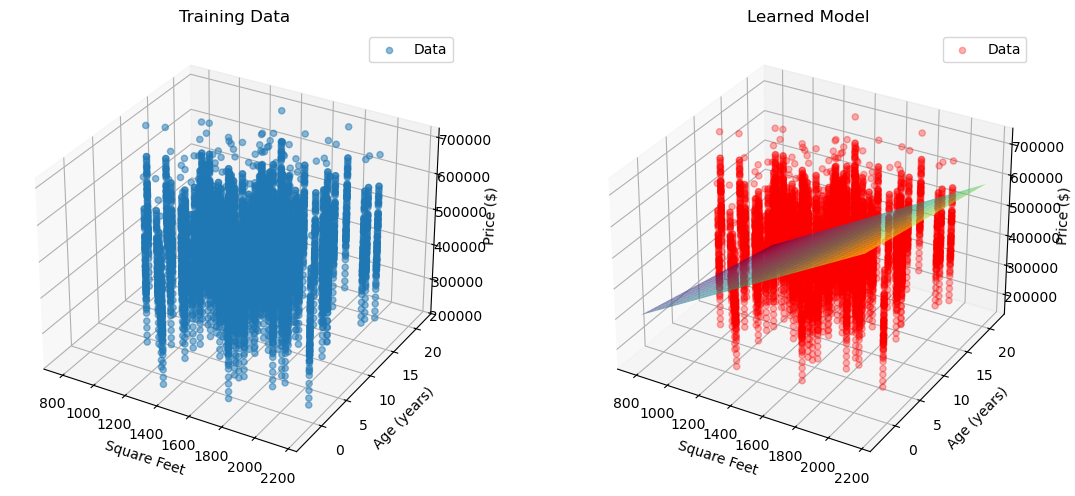

In [4]:
# ============================================================
# 7. Visualize (3D plot)
# ============================================================
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 5))

# Plot 1: Training data
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X[:, 0], X[:, 1], y, alpha=0.5, label='Data')
ax1.set_xlabel('Square Feet')
ax1.set_ylabel('Age (years)')
ax1.set_zlabel('Price ($)')
ax1.set_title('Training Data')
ax1.legend()

# Plot 2: Prediction surface
ax2 = fig.add_subplot(122, projection='3d')
sqft_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 20)
age_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 20)
sqft_grid, age_grid = np.meshgrid(sqft_range, age_range)
X_grid = np.c_[sqft_grid.ravel(), age_grid.ravel()]
X_grid_norm = X_scaler.transform(X_grid)
X_grid_tensor = torch.tensor(X_grid_norm, dtype=torch.float32)

with torch.no_grad():
    y_grid_norm = model(X_grid_tensor).numpy()
    y_grid = y_scaler.inverse_transform(y_grid_norm)

y_grid = y_grid.reshape(sqft_grid.shape)

ax2.plot_surface(sqft_grid, age_grid, y_grid, alpha=0.6, cmap='viridis')
ax2.scatter(X[:, 0], X[:, 1], y, alpha=0.3, c='red', label='Data')
ax2.set_xlabel('Square Feet')
ax2.set_ylabel('Age (years)')
ax2.set_zlabel('Price ($)')
ax2.set_title('Learned Model')
ax2.legend()

plt.tight_layout()
plt.show()

# 关于标准化，不把参数变回去，把输入标准化，把输出标准化变回去再返回

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

torch.manual_seed(42)

# ============================================================
# 1. Data
# ============================================================
TRUE_W1, TRUE_W2, TRUE_B = 300.0, -5000.0, 50000.0

n = 100
sqft = np.random.randn(n, 1) * 300 + 1500
age = np.random.randn(n, 1) * 5 + 10
noise = np.random.randn(n, 1) * 10000

X = np.hstack([sqft, age])
y = TRUE_W1 * sqft + TRUE_W2 * age + TRUE_B + noise

# ============================================================
# 2. Standardize
# ============================================================
X_mean, X_std = X.mean(axis=0), X.std(axis=0)
y_mean, y_std = y.mean(), y.std()

X_norm = (X - X_mean) / X_std
y_norm = (y - y_mean) / y_std

X_train = torch.tensor(X_norm, dtype=torch.float32)
y_train = torch.tensor(y_norm, dtype=torch.float32)

# ============================================================
# 3. Train
# ============================================================
model = nn.Linear(2, 1)
optimizer = optim.Adam(model.parameters(), lr=0.01)

for _ in range(2000):
    loss = ((model(X_train) - y_train) ** 2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# ============================================================
# 4. Predict (auto denormalize)
# ============================================================
def predict(sqft_val, age_val):
    x = np.array([[sqft_val, age_val]])
    x_norm = (x - X_mean) / X_std
    x_tensor = torch.tensor(x_norm, dtype=torch.float32)
    with torch.no_grad():
        y_norm = model(x_tensor).numpy()
    return (y_norm * y_std + y_mean)[0, 0]

# ============================================================
# 5. Test
# ============================================================
print("Predictions:")
for s, a in [(1000, 5), (1500, 10), (2000, 15), (2500, 20)]:
    pred = predict(s, a)
    true = TRUE_W1 * s + TRUE_W2 * a + TRUE_B
    print(f"{s} sqft, {a} years -> ${pred:,.0f} (true: ${true:,.0f})")

Predictions:
1000 sqft, 5 years -> $326,046 (true: $325,000)
1500 sqft, 10 years -> $450,924 (true: $450,000)
2000 sqft, 15 years -> $575,802 (true: $575,000)
2500 sqft, 20 years -> $700,680 (true: $700,000)
